### **Name : NGUEPONWOUO Joseph-Marie**

### **NUMERICAL METHODS FOR PDE IN FINANCE : AMERICAN OPTIONS**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import time
import numpy.linalg as lng
from scipy.sparse import csr_matrix as sparse
from scipy.sparse.linalg import spsolve

$$
min(∂_t v + \mathbb{A} v, v - \varphi) = 0 \\
v(t, S_{min}) = v_l(t) \\
v(t, S_{max} = v_r(t) = 0 \\
v(0, s) = \varphi (s) \\
\mathbb{A} v = -\frac{\sigma ^2}{2}s^2 ∂_{s,s} v - rs ∂_s v + rv
$$

# **1. Explicit Euler Scheme**

$min(\frac{U_j^{n+1} - U_j^n}{\Delta t} + \frac{\sigma^2}{2}s_j^2 \frac{-U_{j-1}^n + 2U_j^n - U_{j+1}^n}{h^2} - rs_j \frac{U_{j+1}^n - U_{j-1}^n}{2h} + rU_j^n,   U_j^{n+1} - \varphi(s_j)) = 0 \\ n = 0, ... N-1 ; j = 1, ... , I $

$U_0^n = v_l(t_n) = Ke^{-rt_n} - S_{min} ; n = 0, ..., N$


$U_{I+1}^n = v_r(t_n) = 0 ;  n = 0, ..., N$


$U_j^0 = \varphi (s_j) = (K - s_j)_+ ; j = 1, ... ,I$




*   Vector form


$$U^{n+1} = max(U^n - \Delta t (AU^n + q(t_n)), g) \\
g \in \mathbb{R}^I, \  g_j = \varphi(s_j)
$$




## **Code corresponding to the Euler Forward scheme**




In [9]:
# All the methods have been added in the class below
class AmericanOptionEuler:
    def __init__(self, Smin = 50, Smax = 250, K = 100, I = 20, T = 1, N = 20, sigma = 0.3, r = 0.1, scheme='EE'):
        self.r = r
        self.sigma = sigma
        self.K = K
        self.T = T
        self.Smin = Smin
        self.Smax = Smax
        self.I = I
        self.N = N
        self.scheme = scheme
        self.dt = T / N
        self.h = (Smax - Smin) / (I + 1)
        self.s = Smin + self.h * np.arange(1, I + 1)
        self.g = self.phi(self.s)
        self.U = self.g
        self.alpha = sigma**2 * self.s**2 / (2 * self.h**2)
        self.beta = r * self.s / (2 * self.h)


    def phi(self,s):
      return np.maximum(self.K - s, 0).reshape(self.I, 1)

    def phi_2(self, s):
      t = [0] * len(s)
      for i in range (len(s)):
        if self.K/2 <= s[i] <= self.K:
          t[i] = self.K
        else:
          t[i] = 0
      return np.array(t).reshape(self.I, 1)

    def v_left(self, t):
      return self.K - self.Smin

    def v_right(self, t):
      return 0

    def construct_A(self):
        A = np.zeros((self.I, self.I))
        for j in range(0, self.I):
          A[j, j] = 2 * self.alpha[j] + self.r
          if j-1 >= 0:
            A[j, j-1] = - self.alpha[j] + self.beta[j]
          if j+1 < self.I:
            A[j, j+1] = - self.alpha[j] - self.beta[j]
        return A

    def q(self, t):
        y = np.zeros((self.I, 1))
        y[0] = (-self.alpha[0] + self.beta[0]) * self.v_left(t)
        y[-1] = (-self.alpha[-1] - self.beta[-1]) * self.v_right(t)
        return y

    def explicit_euler(self):
        A = self.construct_A()
        for n in range(self.N):
            t = n * self.dt
            self.U = np.maximum(self.U - self.dt * (A @ self.U + self.q(t)), self.g)
        return self.U

    def explicit_euler_one_iter(self):
        A = self.construct_A()
        for n in range(1):
            t = n * self.dt
            self.U = np.maximum(self.U - self.dt * (A @ self.U + self.q(t)), self.g)
        return self.U

    def implicit_euler_split(self):
        A = self.construct_A()
        Id = np.identity(self.I)
        for n in range(self.N):
            t = (n+1) * self.dt
            self.U = np.maximum(lng.solve(Id + self.dt * A, self.U - self.dt * self.q(t)), self.g)
        return self.U

    def implicit_euler_psor(self):
        A = self.construct_A()
        Id = np.identity(self.I)
        B = Id + self.dt * A
        for n in range(self.N):
            t = (n+1) * self.dt
            b = self.U - self.dt * self.q(t)
            self.U = PSOR(B, b, self.g, self.U, eta = 1e-1, kmax = 100)
        return self.U

    def implicit_euler_newton(self):
      A = self.construct_A()
      Id = np.identity(self.I)
      B = Id + self.dt * A
      for n in range(self.N):
        t = (n + 1) * self.dt
        b = self.U - self.dt * self.q(t)
        self.U = newton(F_example, F_prime_example, self.U, eta = 1e-6, kmax = 100, B = B, b = b, g = self.g)
      return self.U

    def implicit_euler_brennan(self):
      A = self.construct_A()
      Id = np.identity(self.I)
      B = Id + self.dt * A
      L, U = ul_decomposition(B)
      #print("L:", L)
      #print("U:", U)
      for n in range(self.N):
        t = (n + 1) * self.dt
        b = self.U - self.dt * self.q(t)
        c = solve_upwind(U, b)
        self.U = descente_p(L, c, self.g)
      return self.U

    def higher_order_bdf_scheme(self):
      A = self.construct_A()
      Id = np.identity(self.I)
      B = (3/2)* Id + self.dt * A
      U_first = self.g
      U_second = self.explicit_euler_one_iter()
      for n in range(self.N):
        t = (n + 1) * self.dt
        b = (4 * U_second - U_first) / 2 - self.dt * self.q(t)
        self.U = np.maximum(lng.solve(B, b), self.g)
        U_first, U_second = U_second, self.U
      return self.U


    def implicit_crank_nicolson(self):
       A = self.construct_A()
       Id = np.identity(self.I)
       B = Id + (self.dt / 2) * A
       C = Id - (self.dt / 2) * A
       for n in range(self.N):
           t = (n + 1) * self.dt
           self.U = np.maximum(lng.solve(B, C @ self.U - (self.dt / 2) * (self.q(t - self.dt) + self.q(t))), self.g)
       return self.U

    def interpolate_value(self, s_bar):
        for i in range(len(self.s) - 1):
            if self.s[i] <= s_bar <= self.s[i + 1]:
                s_i, s_ip1 = self.s[i], self.s[i + 1]
                if self.scheme == 'EE-AMER':
                    temp = self.explicit_euler()
                elif self.scheme == 'IE-AMER-SPLIT':
                    temp = self.implicit_euler_split()
                elif self.scheme == 'IE-AMER-CN':
                    temp = self.implicit_crank_nicolson()
                elif self.scheme == 'EI-AMER-PSOR':
                    temp = self.implicit_euler_psor()
                elif self.scheme == 'EI-AMER-NEWTON':
                    temp = self.implicit_euler_newton()
                elif self.scheme == 'EI-AMER-UL':
                    temp = self.implicit_euler_brennan()
                elif self.scheme == 'HO-AMER-BDF':
                    temp = self.higher_order_bdf_scheme()
                else:
                    raise ValueError("Invalid scheme. Choose 'EE', 'IE', or 'CN'.")
                U_i, U_ip1 = temp[i], temp[i + 1]
                interpolated_value = ((s_ip1 - s_bar) / self.h) * U_i + ((s_bar - s_i) / self.h) * U_ip1
                return interpolated_value[-1]
        raise ValueError("s_bar is out of bounds.")

    def compute_error_table(self, Sval):
        alphas = []
        errex = []
        h_vals = []
        Uvals = []
        alphas = [0.0000, 0.00]
        tab = []
        for I_val in [20, 40, 80, 160, 320]:
            #N_val = 2 * (I_val ** 2) // 10
            N_val = I_val
            dt_val = self.T / N_val
            h_val = (self.Smax - self.Smin) / (I_val + 1)
            s_val = self.Smin + h_val * np.arange(1, I_val + 1)

            # Update parameters
            self.dt = dt_val
            self.h = h_val
            self.s = s_val
            self.I = I_val
            self.N = N_val
            self.alpha = self.sigma**2 * self.s**2 / (2 * self.h**2)
            self.beta = self.r * self.s / (2 * self.h)
            self.g = self.phi(self.s)
            self.U = self.g
            exact = np.maximum(self.K - Sval, 0)


            start_time = time.time()
            U_ = self.interpolate_value(Sval)
            end_time = time.time()
            h_vals.append(h_val)
            Uvals.append(U_)
            errex.append(abs(U_ - exact))
            tab.append([I_val, N_val, U_, abs(U_ - exact), end_time - start_time])

        tab[0][3] = 0
        errors = [abs(Uvals[j+1] - Uvals[j]) for j in range(len(Uvals)-1)]
        errors.insert(0, 0)
        orders = []
        for k in range(2, len(Uvals)):
            alpha_k = (np.log(abs(Uvals[k-2]- Uvals[k-1]) / abs(Uvals[k] - Uvals[k-1]))) / (np.log(h_vals[k - 1] / h_vals[k]))
            alphas.append(alpha_k)
            beta_k = alpha_k / 2
            orders.append([k, alpha_k, beta_k])
        tab = np.insert(tab, 3, errors, axis=1)
        tab = np.insert(tab, 4, alphas, axis=1)
        tab = np.array(tab)
        df = pd.DataFrame(tab, columns=['I', 'N', 'U(s)', 'error', 'alpha', 'errex', 'tcpu'])
        return df


    def run(self):
        if self.scheme == 'EE-AMER':
            self.explicit_euler()
        elif self.scheme == 'IE-AMER-SPLIT':
            self.implicit_euler_split()
        elif self.scheme == 'IE-AMER-CN':
            self.implicit_crank_nicolson()
        elif self.scheme == 'EI-AMER-PSOR':
            self.implicit_euler_psor()
        elif self.scheme == 'EI-AMER-NEWTON':
            self.implicit_euler_newton()
        elif self.scheme == 'EI-AMER-UL':
            self.implicit_euler_brennan()
        elif self.scheme == 'HO-AMER-BDF':
            self.higher_order_bdf_scheme()
        else:
            raise ValueError("Invalid scheme. Choose 'EE', 'IE', or 'CN'.")

        plt.plot(self.s, self.U, label = 'Scheme')
        plt.plot(self.s, [max(self.K - p, 0) for p in self.s], 'r--', label = 'Payoff')
        plt.xlabel('Stock Price')
        plt.ylabel('Option Value')
        plt.title(f'American Put Option - {self.scheme} (T = {self.T})')
        plt.legend()
        plt.grid()
        plt.show()



*   **Check that the program does give a stable solution for the parameters $I = 20$ and $N = 20$**




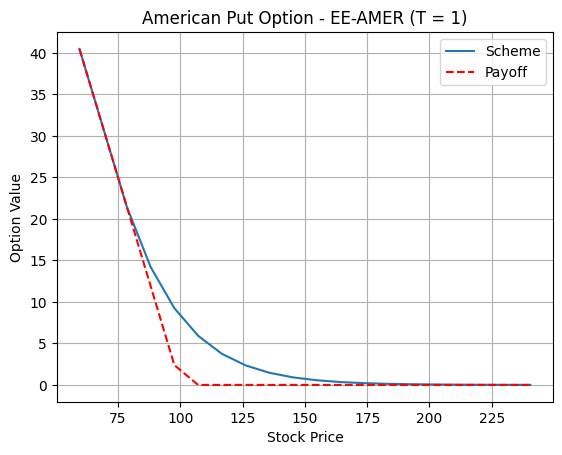

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=20, N=20, scheme='EE-AMER')
option.run()



*   **Check that there is an unstable behavior with other parameters : $I = 50$ and $N = 20$**




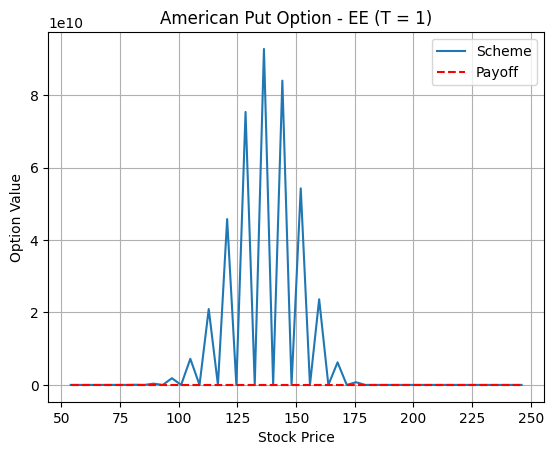

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=50, N=20, scheme='EE')
option.run()



*   **Approximation of $\bar{v}$**




In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=20, N=20, scheme='EE')
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,19.0,72.0,12.948855,0.000000,0.000000,0.000000,0.001226
1,39.0,304.0,13.064946,0.116091,0.000000,3.064946,0.006109
2,79.0,1248.0,13.109601,0.044655,1.378354,3.109601,0.013975
3,159.0,5056.0,13.117808,0.008207,2.443830,3.117808,0.128860
4,319.0,20352.0,13.119988,0.002179,1.913023,3.119988,0.996035


## **2. A First Implicit Scheme : the splitting scheme**



*   Compute $\frac{U^{n+1, (1)} - U^n}{\Delta t} + AU^{n+1, (1)} + q(t_{n+1}) = 0$
*   $U^{n+1} = max(U^{n+1, (1)}, g)$

So here, the iterative formula is given by:

$$
  U^{n+1}  = max(\ (Id + \Delta t \  A)^{-1} (U^n - \Delta t \ q(t_{n+1})), \ g)
$$



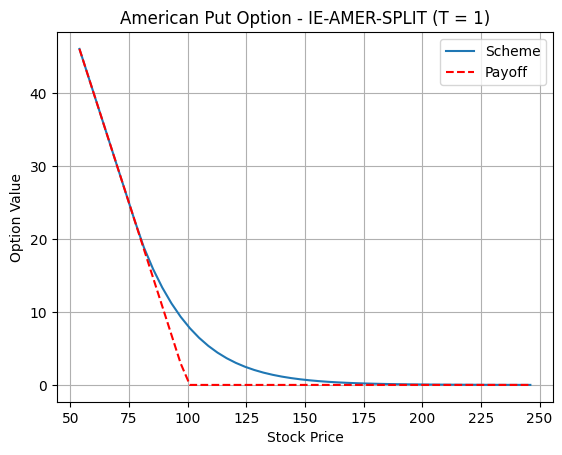

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=50, N=20, scheme='IE-AMER-SPLIT')
option.run()



*   **Convergence table**




In [ ]:
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,19.0,72.0,12.890131,0.000000,0.000000,0.000000,0.007554
1,39.0,304.0,13.045140,0.155009,0.000000,3.045140,0.024280
2,79.0,1248.0,13.105203,0.060063,1.367801,3.105203,0.223245
3,159.0,5056.0,13.116548,0.011344,2.404500,3.116548,5.080357
4,319.0,20352.0,13.119674,0.003126,1.859626,3.119674,79.097900


**Remark** : We can notice from the above plot that the solution is more stable compared to the one of the explicit scheme.



*   **Propose a variant of the previous scheme**

$$
\frac{U_j^{n+1} - U_j^n}{Δ t} + \frac{1}{2} \left( AU^{n+1} + q(t_{n+1}) \right) + \frac{1}{2} \left( AU^{n} + q(t_{n}) \right) = 0 \\ \implies \left( Id + \frac{1}{2} \Delta t A \right)U^{n+1} = (Id - \frac{1}{2}\Delta t A)U^n - \frac{1}{2} \Delta t \left(  q(t_n) + q(t_{n+1}) \right) \\ \implies U^{n+1} = max(\left( Id + \frac{1}{2} \Delta t A \right)^{-1} (Id - \frac{1}{2}\Delta t A)U^n - \frac{1}{2} \Delta t \left(  q(t_n) + q(t_{n+1}) \right), g)
$$





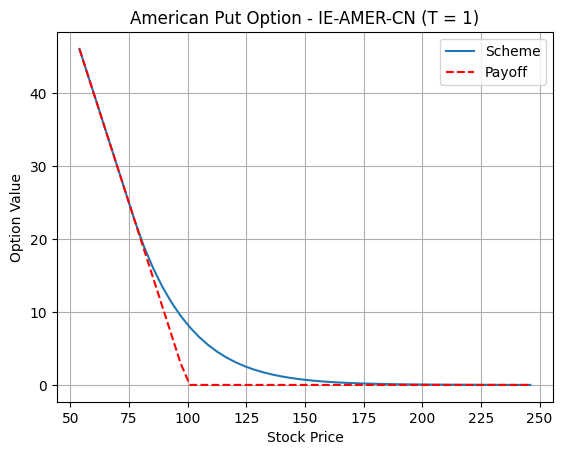

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=50, N=20, scheme='IE-AMER-CN')
option.run()



*   **Convergence table**




In [ ]:
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,19.0,72.0,12.920051,0.000000,0.000000,0.000000,0.003629
1,39.0,304.0,13.054909,0.134858,0.000000,3.054909,0.030367
2,79.0,1248.0,13.107405,0.052496,1.361163,3.107405,0.227199
3,159.0,5056.0,13.117173,0.009768,2.426061,3.117173,3.209356
4,319.0,20352.0,13.119830,0.002657,1.878188,3.119830,94.037989


## **3. Implicit Euler Scheme**

$$
min(\frac{U^{n+1} - U^n}{\Delta t} + AU^{n+1} + q(t_{n+1}), \  U^{n+1} - g) = 0 \\
U^0 = g\\
B := I_d + \Delta t \ A \\
b := U^n - \Delta t  \ q(t_{n+1}) \\
min (Bx - b, x - g) = 0 \, x \in \mathbb{R}^I \\
U^{n+1} = x
$$

##**3.1 PSOR Algorithm (PSOR = "Projected Successive Over Relaxation")**



*   **Check that the solution $x = x^{k+1}$ of $min(Lx - (b - Ux^k), x - g) = 0$ can be programmed in the following pseudo-code :**



In [ ]:
#####################
'''
for i in range(1, n):
  x[i] = (b[i] - sum_{j = 1, ..., I, j != i} (B[i, j] * x[j])) / B[i, i]
  x[i] = max(x[i], g[i])
'''
#####################

**Proof:** First of all, we can notice that the two functions are increasing functions of $x$ so we can check for value of $x$ for which the two functions are equal to zero and then, set x to be the maximum of the two.

$$
Lx - (b-U \ x^k) = 0 \\
(Lx)_i = (b - U \ x^k)_i
$$
The structure of $L$ (lower triangular) and $U$ (upper triangular) and the fact that we start by the first line of matrix $L$ makes the pseudo-code correct.



* **Complete the iterative method in a function PSOR**




In [ ]:
def PSOR(B, b, g, x0, eta, kmax):
    n = len(b)
    x = x0.copy()
    k = 1

    while k < kmax:
        x_old = x.copy()
        for i in range(n):
            sum_except_i = np.sum(B[i, :] * x) - B[i, i] * x[i]

            x[i] = (b[i] - sum_except_i) / B[i, i]

            x[i] = max(x[i], g[i])

        err1 = lng.norm(x - x_old)
        err2 = lng.norm(np.minimum(B @ x - b, x - g))

        print("k=%3i, |x-xold|=%10.6f, |min(Bx-b,x-g)|=%10.6f" % (k, err1, err2))

        if err1 <= eta:
            print("Converged in %d iterations." % k)
            return x
        k += 1
    print("WARNING: Maximum iterations reached. Solution may not have converged.")
    return x

In [ ]:
def PSOR(B, b, g, x0, eta=1e-1, kmax=1000):
    x = np.array(x0, copy=True, dtype=float)
    n = len(x)
    k = 1

    while k < kmax :
        x_old = x.copy()

        for i in range(n):
            sum_offdiag = 0.0
            for j in range(n):
                if j != i:
                    sum_offdiag += B[i, j] * x[j]

            x[i] = (b[i] - sum_offdiag) / B[i, i]

            if x[i] < g[i]:
                x[i] = g[i]

        err1 = np.linalg.norm(x - x_old)
        err2 = np.linalg.norm(np.minimum(B @ x - b, x - g))

        print("k=%3d, |x - x_old|=%.6e, |min(Bx-b, x-g)|=%.6e" % (k, err1, err2))

        if err1 <= eta:
            print(f"Convergence reached at iteration k={k}.")
            return x
        k += 1

    print(f"WARNING: maximum number of iterations (kmax={kmax}) reached.")
    return x


k=  1, |x - x_old|=1.101387e+00, |min(Bx-b, x-g)|=3.824036e+01
k=  2, |x - x_old|=7.573657e-01, |min(Bx-b, x-g)|=2.642782e+01
k=  3, |x - x_old|=5.988323e-01, |min(Bx-b, x-g)|=2.169534e+01
k=  4, |x - x_old|=5.075527e-01, |min(Bx-b, x-g)|=1.899141e+01
k=  5, |x - x_old|=4.541934e-01, |min(Bx-b, x-g)|=1.682820e+01
k=  6, |x - x_old|=4.054264e-01, |min(Bx-b, x-g)|=1.529618e+01
k=  7, |x - x_old|=3.736798e-01, |min(Bx-b, x-g)|=1.404325e+01
k=  8, |x - x_old|=3.429566e-01, |min(Bx-b, x-g)|=1.291749e+01
k=  9, |x - x_old|=3.146415e-01, |min(Bx-b, x-g)|=1.198724e+01
k= 10, |x - x_old|=2.946085e-01, |min(Bx-b, x-g)|=1.122660e+01
k= 11, |x - x_old|=2.759148e-01, |min(Bx-b, x-g)|=1.052898e+01
k= 12, |x - x_old|=2.582222e-01, |min(Bx-b, x-g)|=9.886692e+00
k= 13, |x - x_old|=2.417335e-01, |min(Bx-b, x-g)|=9.295809e+00
k= 14, |x - x_old|=2.264740e-01, |min(Bx-b, x-g)|=8.761044e+00
k= 15, |x - x_old|=2.135871e-01, |min(Bx-b, x-g)|=8.308568e+00
k= 16, |x - x_old|=2.027122e-01, |min(Bx-b, x-g)|=7.892

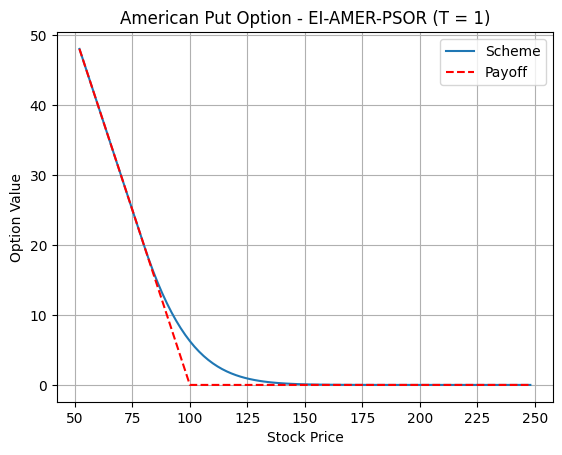

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=99, N=3, scheme='EI-AMER-PSOR')
option.run()

## **3.2 Semi-smooth Newton's method**

$$
F(x) = 0 \  \ \ ; F(x) := min(Bx - b, x - g)
$$

Iteration : $x^{k+1} = x^k - F'(x^k)^{-1}F(x^k)$

Stopping conditions : $F(x^k) = 0$ or $x^{k+1} = x^k$

$$
F'(x^k)_{i, j} = \left\{
    \begin{array}{ll}
        B_{i, j}  & \mbox{if} \ (Bx^k - b)_i \leq (x^k - g)_i \\
        \delta_{i, j} & \mbox{otherwise}
    \end{array}
\right.
$$



*   **Write the code of Newton's method in a function *newton***


In [ ]:
def F_example(B, b, g, x):
    return np.minimum(B @ x - b, x - g)

def F_prime_example(B, b, g, x):
    n = len(x)
    F_prime = np.zeros((n, n))
    for i in range(n):
        if (B @ x - b)[i] <= (x - g)[i]:
            F_prime[i, :] = B[i, :]
        else:
            F_prime[i, i] = 1
    return F_prime

def newton(F, F_prime, x0, eta, kmax, B, b, g):
    x = x0.copy()
    for k in range(kmax):
        Fx = F(B, b, g, x)
        F_prime_x = F_prime(B, b, g, x)

        dx = lng.solve(F_prime_x, -Fx)

        x = x + dx

        err = lng.norm(Fx)
        #print(f"k={k}, |F(x)|={err:.6f}")

        if err <= eta:
            #print("Converged in %d iterations." % k)
            return x
    return x



*   Program the implicit Euler scheme using Newton's method : *Done above*
*   Test the method with $N = 20, I = 50$ and the classical payoff function $\varphi_1$



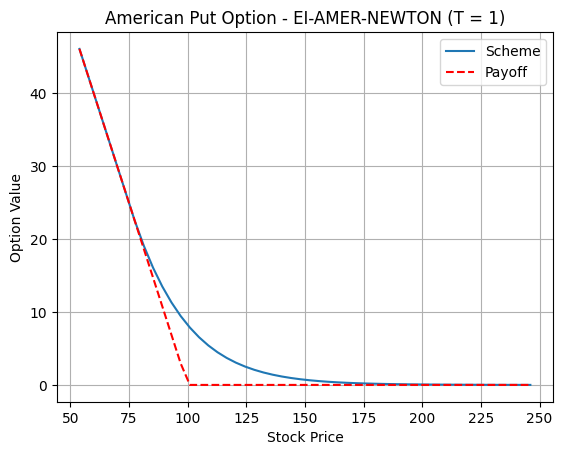

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=50, N=20, scheme='EI-AMER-NEWTON')
option.run()



*   Draw error tables : $N = I$




In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=20, N=20, scheme='EI-AMER-NEWTON')
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,20.0,20.0,13.137800,0.000000,0.000000,0.000000,0.013871
1,40.0,40.0,13.084578,0.053221,0.000000,3.084578,0.055344
2,80.0,80.0,13.106557,0.021979,1.298869,3.106557,0.192780
3,160.0,160.0,13.111972,0.005414,2.039480,3.111972,1.111530
4,320.0,320.0,13.116142,0.004170,0.378387,3.116142,11.279583




*   Draw error tables : $N = I / 10$




In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=20, N=20, scheme='EI-AMER-NEWTON')
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,20.0,2.0,12.719620,0.000000,0.000000,0.000000,0.003668
1,40.0,4.0,12.835853,0.116233,0.000000,2.835853,0.006236
2,80.0,8.0,12.965750,0.129897,-0.163235,2.965750,0.024464
3,160.0,16.0,13.038234,0.072484,0.849222,3.038234,0.163176
4,320.0,32.0,13.077756,0.039522,0.878945,3.077756,1.437687


## **3.3. Brennan and Schwartz Algorithm**


$$
min\ (Bx - b, x - g) = 0 \\
B = UL \ (U_{i,i} = 1 \ ∀i) \\ \implies min (Lx - U^{-1}b, x - g) = 0
$$

In [5]:
def ul_decomposition(B):
    n = B.shape[0]
    L = np.zeros_like(B)
    U = np.eye(n)
    for i in range(n):
        L[i, i] = B[i, i]

    for i in range(n-1):
        U[i, i+1] = B[i, i+1] / B[i+1, i+1]
        L[i+1, i] = B[i+1, i]


    #print('norme de B-UL:',lng.norm(B-U@L, np.inf))
    return L, U

def solve_upwind(U, b):
    n = len(b)
    c = np.zeros_like(b)

    for i in range(n - 1, -1, -1):
        c[i] = b[i] - np.dot(U[i, i+1:], c[i+1:])
    return c

def descente_p(L, c, g):
    n = len(c)
    x = np.zeros_like(c)

    for i in range(n):
        x[i] = max((c[i] - np.dot(L[i, :i], x[:i])) / L[i, i], g[i])

    print("||min(Bx−b,x−g)||:", lng.norm(np.minimum(L@x - g, x - g)))
    return x



*  **Test the method for $N = 20, I = 49$**




||min(Bx−b,x−g)||: 2.647301057881577e-23
||min(Bx−b,x−g)||: 1.469181269471013
||min(Bx−b,x−g)||: 1.9419532002858342
||min(Bx−b,x−g)||: 2.077394015210682
||min(Bx−b,x−g)||: 2.1385091259998203
||min(Bx−b,x−g)||: 2.169549073658953
||min(Bx−b,x−g)||: 2.1855511992083936
||min(Bx−b,x−g)||: 2.193876128473527
||min(Bx−b,x−g)||: 2.1982381925221137
||min(Bx−b,x−g)||: 2.20053696708473
||min(Bx−b,x−g)||: 2.2017540384086334
||min(Bx−b,x−g)||: 2.2024008415216816
||min(Bx−b,x−g)||: 2.202745636126504
||min(Bx−b,x−g)||: 2.2029298980386622
||min(Bx−b,x−g)||: 2.2030285711090363
||min(Bx−b,x−g)||: 2.2030814994682806
||min(Bx−b,x−g)||: 2.203109929279275
||min(Bx−b,x−g)||: 2.2031252172103137
||min(Bx−b,x−g)||: 2.203133445807879
||min(Bx−b,x−g)||: 2.203137878161421


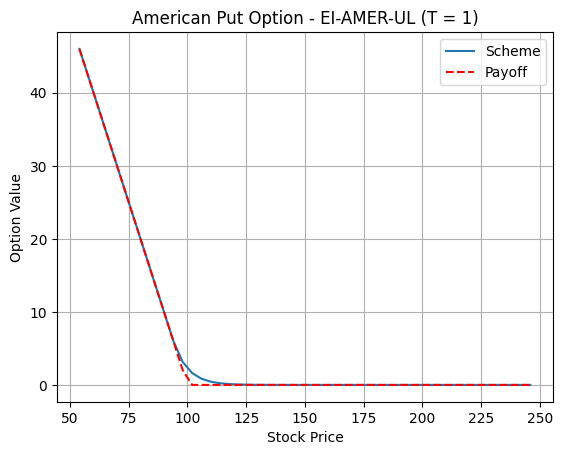

In [10]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=49, N=20, scheme='EI-AMER-UL')
option.run()



*  Run the program again with the particular payoff $\varphi_2$ instead of $\varphi_1$. Check that in that case $min(Bx - b, x - g) \neq 0$ as soon as $n = 0$.


$$
\varphi_2(s) = \left\{
    \begin{array}{ll}
        K  & \mbox{if} \ \frac{K}{2} \leq s \leq K \\
        0 & \mbox{otherwise}
    \end{array}
\right.
$$




||min(Bx−b,x−g)||: 12.59575359939473
||min(Bx−b,x−g)||: 43.42925854627938
||min(Bx−b,x−g)||: 60.89000591469507
||min(Bx−b,x−g)||: 67.86618374938274
||min(Bx−b,x−g)||: 72.3186475616518
||min(Bx−b,x−g)||: 75.71036229026303
||min(Bx−b,x−g)||: 78.46494397282096
||min(Bx−b,x−g)||: 80.79200831929052
||min(Bx−b,x−g)||: 82.81416059674221
||min(Bx−b,x−g)||: 84.60754262037001
||min(Bx−b,x−g)||: 86.22182333291043
||min(Bx−b,x−g)||: 87.6909276003538
||min(Bx−b,x−g)||: 89.03904367994113
||min(Bx−b,x−g)||: 90.2841082398639
||min(Bx−b,x−g)||: 91.43989387831178
||min(Bx−b,x−g)||: 92.51729829372258
||min(Bx−b,x−g)||: 93.52516474332138
||min(Bx−b,x−g)||: 94.4708201813502
||min(Bx−b,x−g)||: 95.36043905069108
||min(Bx−b,x−g)||: 96.19929668520822


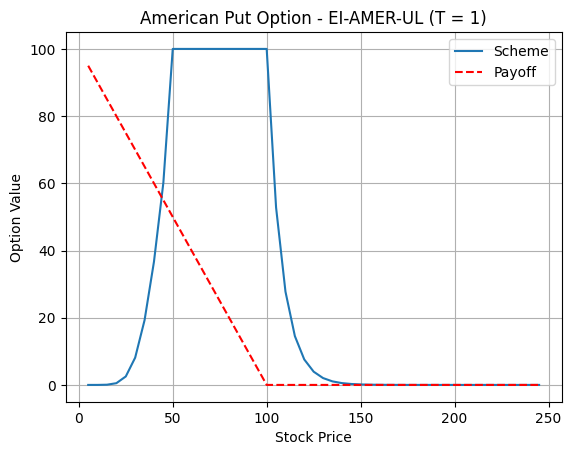

In [8]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=0, Smax=250, I=49, N=20, scheme='EI-AMER-UL')
option.run()

## **4. Higher Order Schemes**




### i) Implicit Euler : Done in section 2
### ii) Crank-Nikolson : Done in section 2
### iii) BDF (Backward Difference Formula) Scheme

$$
U^0 = g \\
min(\frac{3 U^{n+1} - 4 U^n + U^{n-1}}{2 \Delta t} + AU^{n+1} + q(t_{n+1}),
 \ U^{n+1} - g) = 0    
$$

$$
U^{n+1} = max(\left( \frac{3}{2} Id +  \Delta t A \right)^{-1}(\frac{4U^n - U^{n-1}}{2} - \Delta t \ q(t_{n+1})), \  g\ )
$$

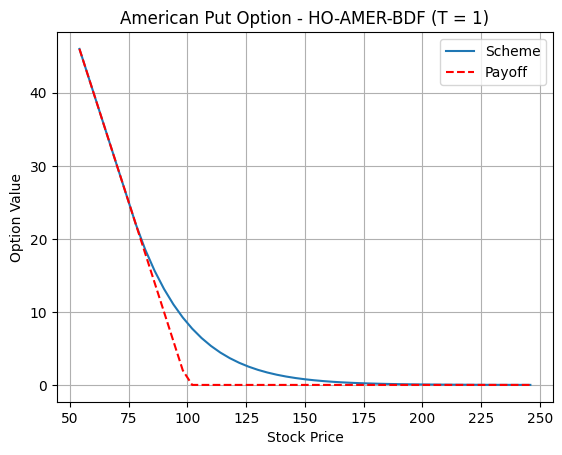

In [ ]:
option = AmericanOptionEuler(r=0.1, sigma=0.3, K=100, T=1, Smin=50, Smax=250, I=49, N=20, scheme='HO-AMER-BDF')
option.run()



*   Table for $N = I / 10$




In [ ]:
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,20.0,20.0,13.230914,0.000000,0.000000,0.000000,0.001306
1,40.0,40.0,13.135376,0.095537,0.000000,3.135376,0.004780
2,80.0,80.0,13.128265,0.007112,3.815358,3.128265,0.033784
3,160.0,160.0,13.122898,0.005367,0.409765,3.122898,0.475919
4,320.0,320.0,13.121262,0.001636,1.722048,3.121262,1.975531




*  Table for $N = I$




In [ ]:
option.compute_error_table(90)

,I,N,U(s),error,alpha,errex,tcpu
0,20.0,20.0,13.230914,0.000000,0.000000,0.000000,0.003254
1,40.0,40.0,13.135376,0.095537,0.000000,3.135376,0.007097
2,80.0,80.0,13.128265,0.007112,3.815358,3.128265,0.013460
3,160.0,160.0,13.122898,0.005367,0.409765,3.122898,0.099361
4,320.0,320.0,13.121262,0.001636,1.722048,3.121262,0.881788


**Remark** : The code in this case is faster than the previous one but more stable in term of values.

$$
$$